In [1]:
!pip install pytorch-lightning torchview torchvision torchinfo torchmetrics torch > /dev/null

#Data Loading and Preprocessing

In this section, we load the Stanford Dogs Dataset, which contains images of various dog breeds. The dataset is preprocessed to transform the images into a suitable format for our model. This includes resizing, random cropping, and normalization. These steps are crucial for consistent input data format and improved model performance.
The dataset is then split into training and validation sets, ensuring we have separate data for training and model evaluation.


In [2]:
import os
import tarfile
import urllib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision import models
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import DataLoader, Subset
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from torchmetrics import Accuracy, Precision, F1Score, ConfusionMatrix


# Function to download and extract the dataset
def download_and_extract_dataset(dataset_url, dataset_path, tar_file_path):
    if not os.path.exists(dataset_path):
        os.makedirs(dataset_path, exist_ok=True)
        print(f"Downloading the dataset from {dataset_url}...")
        urllib.request.urlretrieve(dataset_url, tar_file_path)
        print("Download complete!")
        print("Extracting the dataset...")
        with tarfile.open(tar_file_path, 'r') as tar_ref:
            tar_ref.extractall(path=dataset_path)
        print("Extraction complete!")
    else:
        print("Dataset already downloaded and extracted.")

# Data Preparation
dataset_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
dataset_path = "data/images"
tar_file_path = "data/images.tar"
download_and_extract_dataset(dataset_url, dataset_path, tar_file_path)

# Define the augmentation and transformation steps
augmentations = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the dataset from the 'Images' directory and apply the transformations
images_dir = os.path.join(dataset_path, 'Images')
dataset = ImageFolder(root=images_dir, transform=augmentations)

# Split the dataset into a train and validation set
targets = [label for _, label in dataset.samples]
train_idx, val_idx = train_test_split(
    range(len(targets)),
    test_size=0.2,  # 20% for validation
    random_state=42,  # Seed for reproducibility
    stratify=targets
)

# Create Subset objects to be used as the train and validation datasets
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

# Create DataLoaders for the train and validation datasets
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

class_names = dataset.classes

Download complete!
Extracting the dataset...
Extraction complete!


#Model Definition: DogBreedClassifier

Here, we define our model, `DogBreedClassifier`. This model is based on the DenseNet161 architecture, a powerful convolutional neural network known for its efficiency in image classification tasks. We adapt the final layer to classify 120 dog breeds. The pre-trained layers of the model are frozen to utilize the knowledge gained from the ImageNet dataset, focusing the training on the last layer to categorize dog breeds.


Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 80.9MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | DenseNet                  | 26.7 M
1 | loss_fn   | CrossEntropyLoss          | 0     
2 | train_acc | MulticlassAccuracy        | 0     
3 | val_acc   | MulticlassAccuracy        | 0     
4 | f1        | MulticlassF1Score         |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 1: Validation Loss: 4.836408615112305, Accuracy: 0.0, F1 Score: 0.0, Precision: 0.0


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: Validation Loss: 0.6998775601387024, Accuracy: 0.7896015644073486, F1 Score: 0.7834416627883911, Precision: 0.8206266164779663


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: Validation Loss: 0.6910884380340576, Accuracy: 0.7905733585357666, F1 Score: 0.7834081649780273, Precision: 0.8231307864189148


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: Validation Loss: 0.652996301651001, Accuracy: 0.795432448387146, F1 Score: 0.7917916774749756, Precision: 0.8202711939811707


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: Validation Loss: 0.6655645966529846, Accuracy: 0.8032069802284241, F1 Score: 0.7972226142883301, Precision: 0.8287091255187988


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5: Validation Loss: 0.6548225283622742, Accuracy: 0.8053935766220093, F1 Score: 0.8006352186203003, Precision: 0.8198744058609009
Validation Accuracy List: [0.0, 0.7896015644073486, 0.7905733585357666, 0.795432448387146, 0.8032069802284241, 0.8053935766220093]


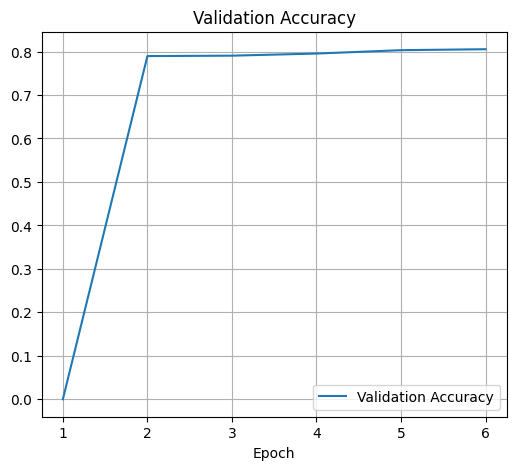

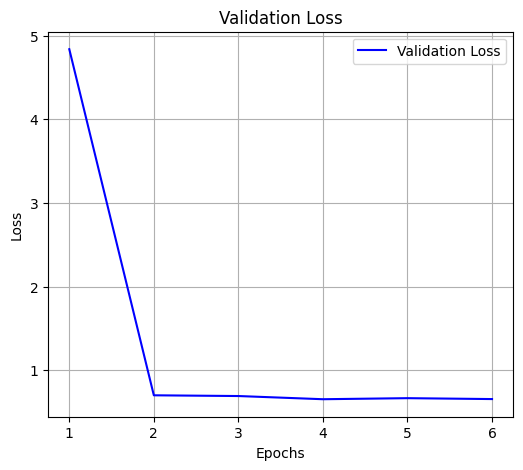

In [3]:
class DogBreedClassifier(pl.LightningModule):
    def __init__(self, num_classes=120):
        super().__init__()
        # Initialize the DenseNet model with the final layer adapted for 120 classes
        self.model = models.densenet161(weights=models.DenseNet161_Weights.IMAGENET1K_V1)
        self.model.classifier = nn.Linear(self.model.classifier.in_features, num_classes)

        # Freeze the pretrained layers
        for param in self.model.features.parameters():
            param.requires_grad = False

        # Define loss function and metrics
        self.loss_fn = nn.CrossEntropyLoss()
        self.train_acc = Accuracy(num_classes=num_classes, task = "multiclass")
        self.val_acc = Accuracy(num_classes=num_classes, task = "multiclass")
        self.f1 = F1Score(num_classes=num_classes, task = "multiclass", average='macro')
        self.precision = Precision(num_classes=num_classes, task = "multiclass", average='macro')
        self.confmat = ConfusionMatrix(num_classes=num_classes, task = "multiclass")
        self.confmat_matrices = []  # To store confusion matrices after each epoch

        # Variables to track validation metrics for each epoch
        self.validation_outputs = []  # To store outputs for the on_validation_epoch_end hook
        self.validation_loss_list = []
        self.validation_acc_list = []
        self.validation_f1_list = []
        self.validation_precision_list = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss_fn(logits, y)
        self.train_acc(logits, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)

        # Calculate metrics manually
        correct = preds.eq(y).sum().item()
        total = y.size(0)
        manual_acc = correct / total

        # Update metrics
        self.val_acc.update(preds, y)
        self.f1.update(preds, y)
        self.precision.update(preds, y)
         # Update confusion matrix
        self.confmat.update(preds, y)


        # Store the outputs for use in the on_validation_epoch_end hook
        self.validation_outputs.append({'val_loss': loss.detach(), 'preds': preds, 'targets': y})
        return {'val_loss': loss.detach()}

    def on_validation_epoch_end(self):
        # Calculate the average of the validation loss using stored outputs
        if self.validation_outputs:
            avg_val_loss = torch.stack([x['val_loss'] for x in self.validation_outputs]).mean()
            avg_val_acc = self.val_acc.compute()
            avg_val_f1 = self.f1.compute()
            avg_val_precision = self.precision.compute()

            # Append the average metrics to the tracking lists
            self.validation_loss_list.append(avg_val_loss.cpu().item())
            self.validation_acc_list.append(avg_val_acc.cpu().item())
            self.validation_f1_list.append(avg_val_f1.cpu().item())
            self.validation_precision_list.append(avg_val_precision.cpu().item())

            # Print the validation metrics
            print(f'Epoch {self.current_epoch + 1}: '
                  f'Validation Loss: {avg_val_loss}, '
                  f'Accuracy: {avg_val_acc}, '
                  f'F1 Score: {avg_val_f1}, '
                  f'Precision: {avg_val_precision}')

            # Log the validation metrics
            self.log('avg_val_loss', avg_val_loss)
            self.log('avg_val_acc', avg_val_acc)
            self.log('avg_val_f1', avg_val_f1)
            self.log('avg_val_precision', avg_val_precision)

            # Compute and store the confusion matrix for the current epoch
            confmat = self.confmat.compute()
            self.confmat_matrices.append(confmat.cpu().numpy())
            self.confmat.reset()

            # Reset metrics after each epoch
            self.val_acc.reset()
            self.f1.reset()
            self.precision.reset()

            # Clear the list of saved outputs for the next epoch
            self.validation_outputs.clear()


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.classifier.parameters(), lr=1e-3)
        return optimizer

# Instantiate the model and trainer with CSVLogger
model = DogBreedClassifier(num_classes=120)
csv_logger = CSVLogger(save_dir='logs/', name='dog_breed_classifier_logs')
trainer = Trainer(
    max_epochs=5,
    logger=csv_logger,
    callbacks=[ModelCheckpoint(monitor='avg_val_loss'), EarlyStopping(monitor='avg_val_loss')]
)

# Assuming 'train_dataloader' and 'val_dataloader' are defined
try:
    trainer.fit(model, train_dataloader, val_dataloader)
except Exception as e:
    print(f"An error occurred during training: {e}")

torch.save(model.state_dict(), 'dog_breed_classifier.pth')

torch.save(model, 'dog_breed_classifier_full.pth')

#print("Validation Loss List:", model.validation_loss_list)
print("Validation Accuracy List:", model.validation_acc_list)

epochs = list(range(1, len(model.validation_loss_list) + 1))
plt.figure(figsize=(6, 5))
plt.plot(epochs, model.validation_acc_list, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.xticks(epochs)
plt.legend()
plt.grid()
plt.show()

# Plot for loss
plt.figure(figsize=(6, 5))
plt.plot(epochs, model.validation_loss_list, 'b-', label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Visualization of Model Predictions

This section is dedicated to visualizing the predictions made by our Dog Breed Classifier. Visualization is key in understanding how well our model is performing and provides a more intuitive understanding of its predictive capabilities.

## Normalization Factors
Before we proceed, it's important to note the normalization factors used in our dataset. Normalization is a critical preprocessing step in many machine learning pipelines, especially in image processing. It involves scaling the pixel values to a standard range, which aids in model training and convergence.


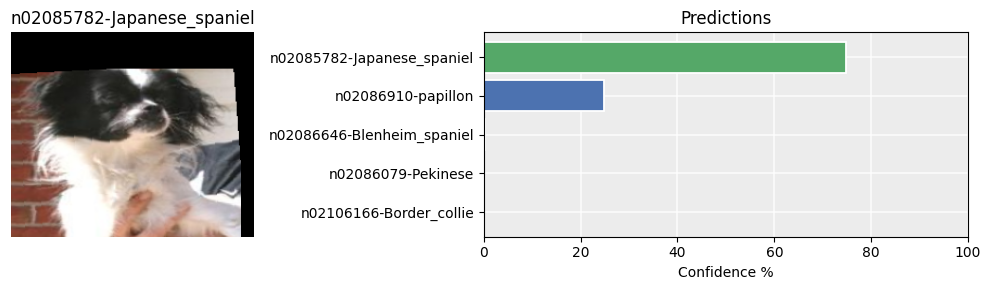

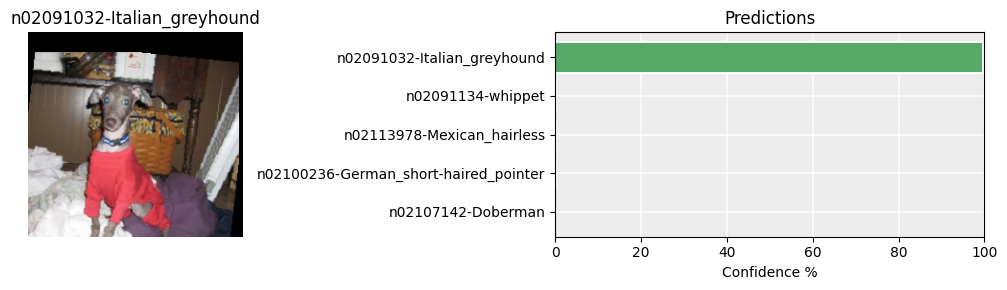

In [4]:
# Normalization factors used in your dataset
NORM_MEAN = torch.tensor([0.485, 0.456, 0.406])
NORM_STD = torch.tensor([0.229, 0.224, 0.225])


class_names = dataset.classes  # This will give you the list of class names

def show_prediction(img, label, pred, K=5):
    # Convert normalization factors to numpy arrays
    norm_mean = NORM_MEAN.numpy()
    norm_std = NORM_STD.numpy()

    if isinstance(img, torch.Tensor):
        # Convert image to numpy array and normalize
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * norm_std) + norm_mean
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Create a figure with a 1x2 grid layout
    fig = plt.figure(figsize=(10, 3))
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 2])

    ax0 = fig.add_subplot(gs[0])
    ax1 = fig.add_subplot(gs[1])

    # Display the image
    #ax0.imshow(img)
    ax0.imshow(img, aspect='auto')
    ax0.set_title(f'{class_names[label]}')
    ax0.axis('off')

    # Compute the softmax probabilities and find the top K predictions
    pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()

    # Assign colors to the bars based on the correct label
    colors = ['#55A868' if i == label else '#4C72B0' for i in topk_idx]

    # Plot the top K predictions with their confidence percentages
    ax1.barh(np.arange(K), topk_vals * 100, color=colors, edgecolor='white', linewidth=1.3)
    ax1.set_yticks(np.arange(K))
    ax1.set_yticklabels([class_names[i] for i in topk_idx])
    ax1.invert_yaxis()  # Highest probabilities on top
    ax1.set_xlabel('Confidence %')
    ax1.set_xlim(0, 100)
    ax1.set_title('Predictions')
    # Set the background to a grid
    ax1.set_facecolor('#ECECEC')  # Light grey background
    # Add gridlines and put them behind the bars
    ax1.xaxis.grid(True, color='white', linestyle='-', linewidth=1.3, alpha=0.7)
    ax1.yaxis.grid(True, color='white', linestyle='-', linewidth=1.3, alpha=0.7)
    ax1.set_axisbelow(True)  # This line ensures the grid is behind the plot

    plt.tight_layout()
    plt.show()


# Check if a GPU is available and set PyTorch to use the GPU, otherwise use the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Now, move your model to the selected device
model.to(device)

# The rest of your code can stay the same
model.eval()
exmp_batch, label_batch = next(iter(val_dataloader))
with torch.no_grad():
    preds = model(exmp_batch.to(device))

# Visualize predictions for the first few images in the batch
for i in range(min(len(exmp_batch), 2)):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])


# Adversarial Attack Techniques and Visualization

In this section, we delve into adversarial machine learning, a critical aspect of understanding model robustness. We implement two well-known adversarial attack techniques: Fast Gradient Sign Method (FGSM) and Projected Gradient Descent (PGD). These methods are designed to test the model's resilience by slightly altering the input images in a way that aims to confuse the model. Understanding how these attacks affect model performance is key to improving the model's robustness against such adversarial examples.

## Normalization Factors
Normalization is an essential preprocessing step in our pipeline. Here, we define the mean and standard deviation for normalizing our images. These values are standard for models trained on the ImageNet dataset.

<ipython-input-5-a440cab85eb0>:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


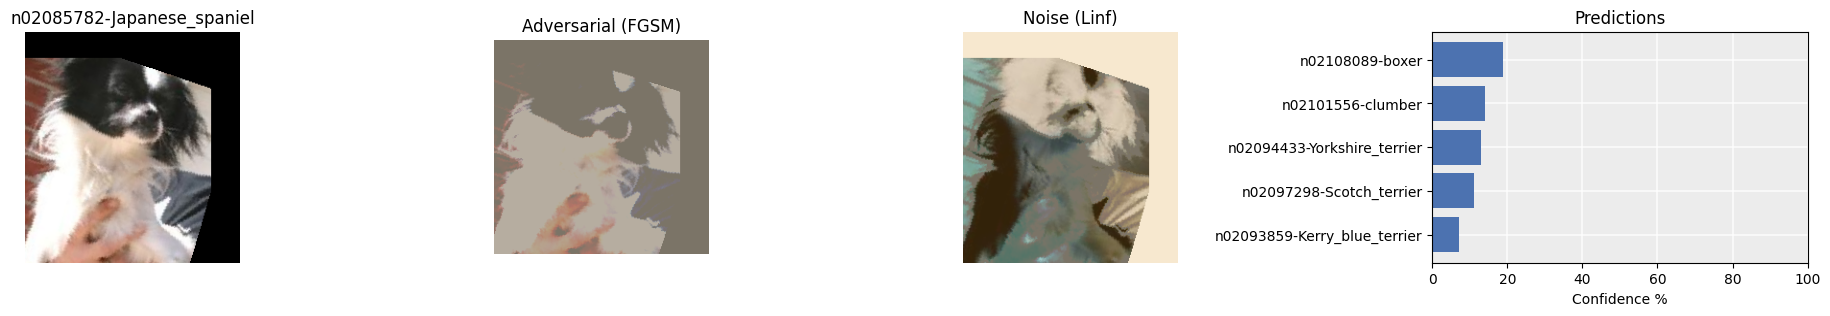

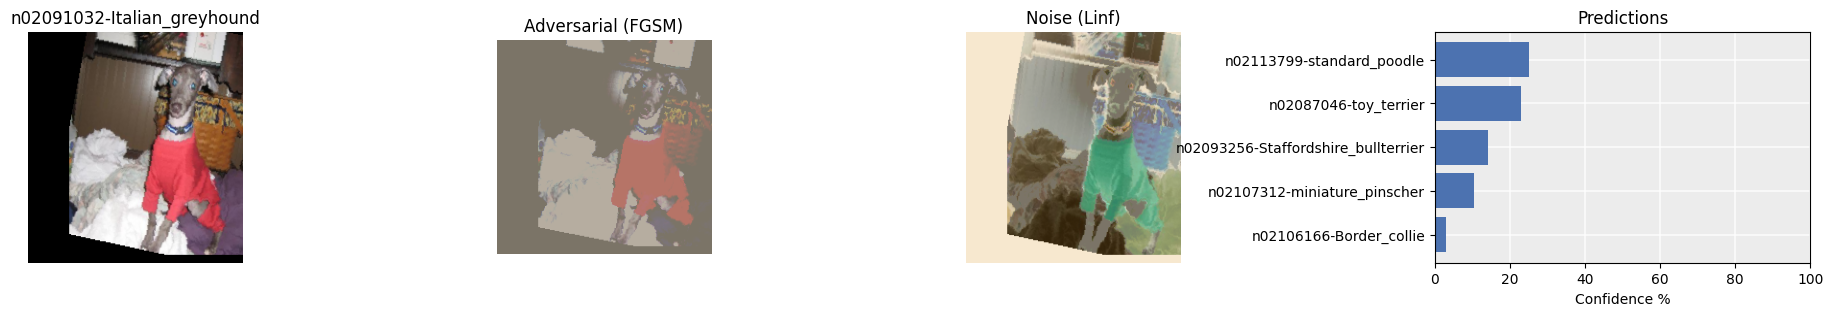

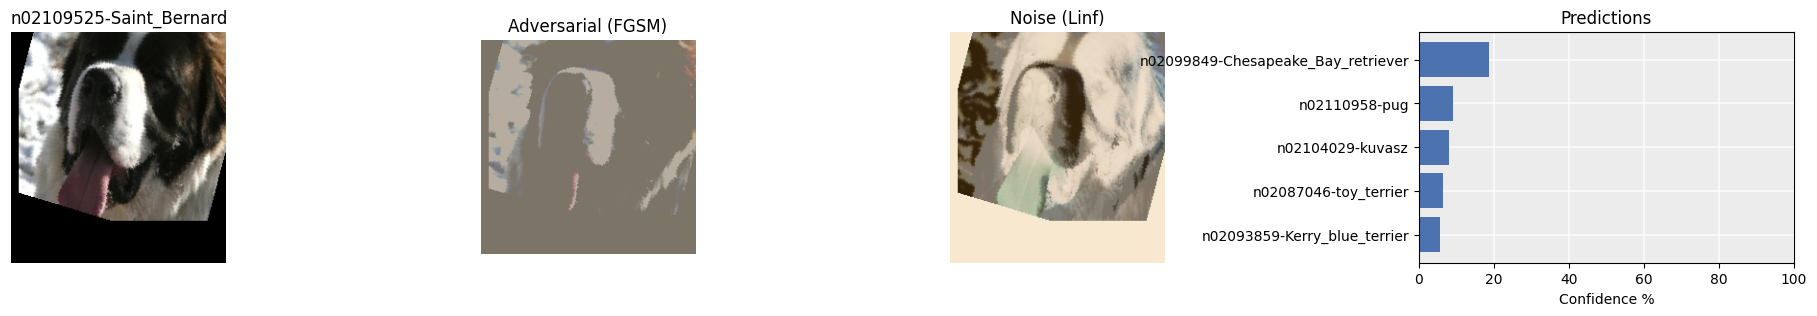

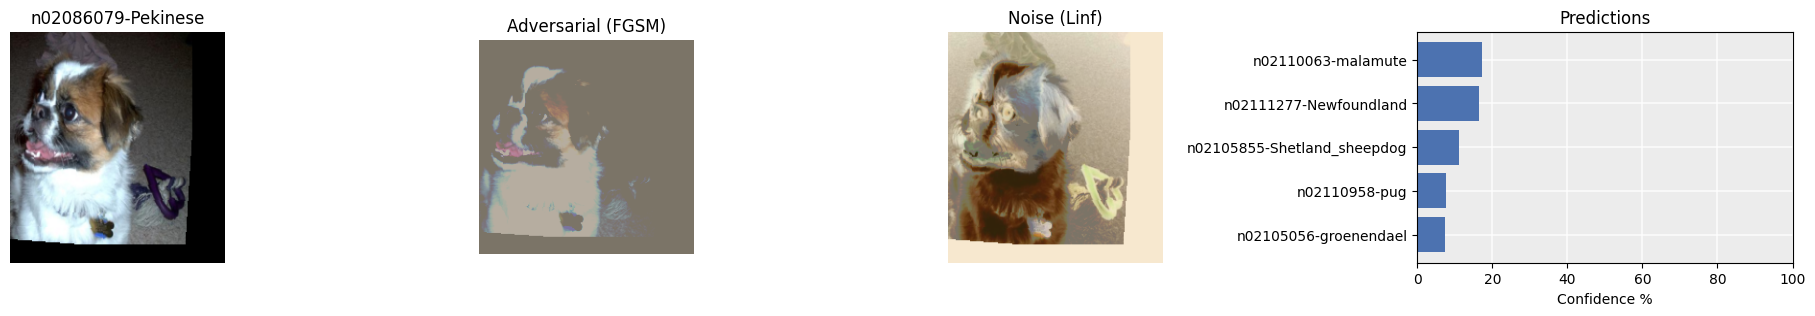

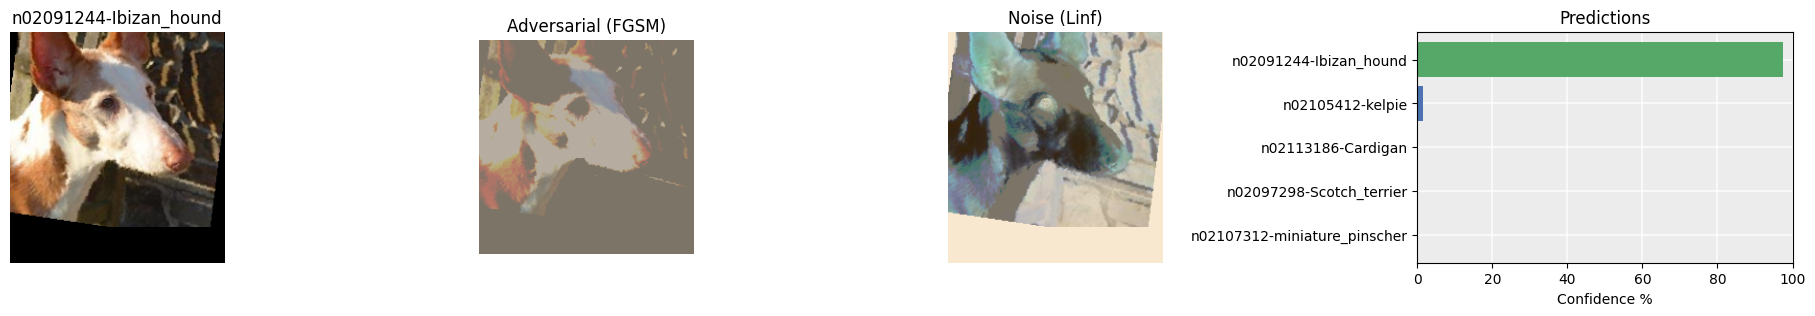

In [5]:
# Normalization factors used in your dataset
NORM_MEAN = torch.tensor([0.485, 0.456, 0.406])
NORM_STD = torch.tensor([0.229, 0.224, 0.225])

class_names = dataset.classes

# Functions to create adversarial examples
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

def pgd_attack(model, images, labels, eps, alpha, iters, norm='L1'):
    # Copy the original images to perturb
    perturbed_images = images.clone().detach().requires_grad_(True)

    for _ in range(iters):
        outputs = model(perturbed_images)
        model.zero_grad()
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        grad = perturbed_images.grad.data

        # Perform the attack step
        if norm == "Linf":
            step = alpha * grad.sign()
        elif norm == "L2":
            g_norm = torch.norm(grad.view(grad.shape[0], -1), dim=1).view(-1, 1, 1, 1)
            step = alpha * grad / (g_norm + 1e-10)
        elif norm == "L1":
            step = alpha * grad / (grad.abs().sum(dim=[1,2,3], keepdim=True) + 1e-10)
        else:
            raise ValueError("Invalid norm choice.")

        # Apply the perturbation step while staying within the epsilon-ball and [0,1] range
        perturbed_images = perturbed_images + step
        perturbed_images = torch.min(torch.max(perturbed_images, images - eps), images + eps)
        perturbed_images = torch.clamp(perturbed_images, 0, 1).detach().requires_grad_(True)

    return perturbed_images

def tensor_to_img(tensor):
    # Move normalization tensors to the same device as the input tensor
    norm_mean = NORM_MEAN.to(tensor.device)
    norm_std = NORM_STD.to(tensor.device)

    tensor = tensor * norm_std[:, None, None] + norm_mean[:, None, None]
    tensor = torch.clamp(tensor, 0, 1)
    # Make sure to detach before calling numpy()
    img = tensor.detach().permute(1, 2, 0).cpu().numpy()
    return img

# Function to visualize adversarial examples
def visualize_adversarial_examples(model, dataloader, device, attack='fgsm', epsilon=0.003, alpha=0.01, iters=10, norm='Linf'):
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)

    if attack == 'fgsm':
        images.requires_grad = True
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()
        data_grad = images.grad.data
        perturbed_images = fgsm_attack(images, epsilon, data_grad)
    elif attack == 'pgd':
        perturbed_images = pgd_attack(model, images, labels, epsilon, alpha, iters, norm)

    # Plot the results
    for i in range(min(len(images), 3)):
        original_img_np = tensor_to_img(images[i])
        perturbed_img_np = tensor_to_img(perturbed_images[i])
        noise_img_np = tensor_to_img(perturbed_images[i] - images[i])
        outputs = model(perturbed_images[i].unsqueeze(0))
        pred_probs, pred_classes = torch.topk(torch.softmax(outputs, dim=1).squeeze(), 5)


        # Plot the results
        fig, axes = plt.subplots(1, 4, figsize=(23, 3), gridspec_kw={'width_ratios': [2, 2, 2, 3.5], 'wspace': 1})

        axes[0].imshow(original_img_np, aspect='auto')
        axes[0].set_title(f'{class_names[labels[i]]}')
        axes[0].axis('off')

        axes[1].imshow(perturbed_img_np)
        axes[1].set_title(f'Adversarial ({attack.upper()})')
        axes[1].axis('off')

        axes[2].imshow(noise_img_np, aspect='auto')
        axes[2].set_title(f'Noise ({norm})')
        axes[2].axis('off')

        # Adjust the confidence bar subplot
        axes[3].barh(np.arange(5), pred_probs.detach().cpu().numpy() * 100,
                    color=['#55A868' if class_names[pred_classes[j]] == class_names[labels[i]] else '#4C72B0' for j in range(5)])
        axes[3].set_yticks(np.arange(5))
        axes[3].set_yticklabels([class_names[pred_classes[j]] for j in range(5)])
        axes[3].invert_yaxis()  # Highest probabilities on top
        axes[3].set_xlabel('Confidence %')
        axes[3].set_title('Predictions')
        axes[3].set_xlim(0, 100)
        axes[3].set_facecolor('#ECECEC')  # Light grey background
        axes[3].xaxis.grid(True, color='white', linestyle='-', linewidth=1.3, alpha=0.7)
        axes[3].yaxis.grid(True, color='white', linestyle='-', linewidth=1.3, alpha=0.7)
        axes[3].set_axisbelow(True)  # This line ensures the grid is behind the plot

        plt.tight_layout()
        plt.show()

# Check if a GPU is available and set PyTorch to use the GPU, otherwise use the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)
visualize_adversarial_examples(model, val_dataloader, device, attack='fgsm', epsilon=0.003)


# Model Accuracy Evaluation

Understanding the performance of our model is crucial. This section is dedicated to evaluating the model's accuracy both on clean data and under adversarial attacks. This evaluation helps us assess not only how well our model performs in standard scenarios but also its robustness against adversarial manipulation.

## Function to Calculate Accuracy
The `calculate_accuracy` function measures the model's accuracy on a given dataset. It iterates through the dataset, makes predictions, and compares them to the actual labels to determine how often the model is correct.


In [6]:
def calculate_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    return accuracy

def calculate_adversarial_accuracy(model, dataloader, device, attack_fn, epsilon, alpha=None, iters=None, norm='Linf'):
    model.eval()
    correct = 0
    total = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        images.requires_grad = True
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()
        data_grad = images.grad.data
        if attack_fn == fgsm_attack:
            adv_images = attack_fn(images, epsilon, data_grad)
        elif attack_fn == pgd_attack:
            adv_images = attack_fn(model, images, labels, epsilon, alpha, iters, norm)
        else:
            raise ValueError("Unknown attack function")
        outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    accuracy = 100 * correct / total
    return accuracy


# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Evaluate clean accuracy
clean_accuracy = calculate_accuracy(model, val_dataloader, device)

# Norms and attack parameters
norms = ['L1', 'L2', 'Linf']
epsilon = 0.003
alpha = 0.01
iters = 10

# Evaluate FGSM and PGD attacks
fgsm_accuracies = {}
pgd_accuracies = {}

# FGSM is typically with Linf norm
fgsm_accuracies['Linf'] = calculate_adversarial_accuracy(
    model, val_dataloader, device, fgsm_attack, epsilon=epsilon
)

# Evaluate PGD for different norms
for norm in norms:
    pgd_accuracies[norm] = calculate_adversarial_accuracy(
        model, val_dataloader, device, pgd_attack, epsilon=epsilon, alpha=alpha, iters=iters, norm=norm
    )


# Print out the accuracies
print(f"Clean Accuracy: {clean_accuracy:.2f}%")
print(f"FGSM (Linf) Accuracy: {fgsm_accuracies['Linf']:.2f}%")
for norm in norms:
    print(f"PGD ({norm}) Accuracy: {pgd_accuracies[norm]:.2f}%")


Clean Accuracy: 80.81%
FGSM (Linf) Accuracy: 18.93%
PGD (L1) Accuracy: 20.72%
PGD (L2) Accuracy: 18.32%
PGD (Linf) Accuracy: 5.20%



# Adversarial Training Implementation

This code section defines a PyTorch Lightning module for a dog breed classifier with adversarial training. The classifier is based on the DenseNet-161 architecture, and the training process includes adversarial examples using the Fast Gradient Sign Method (FGSM) and Projected Gradient Descent (PGD). Adversarial training starts from the 5th epoch.


In [7]:
class DogBreedClassifier(pl.LightningModule):
    def __init__(self, num_classes=120, adv_training_start_epoch=5):
        super().__init__()
        self.automatic_optimization = False
        self.model = models.densenet161(pretrained=True)
        self.model.classifier = nn.Linear(self.model.classifier.in_features, num_classes)

        # Freeze the pretrained layers
        for param in self.model.features.parameters():
            param.requires_grad = False

        # Define loss function and metrics
        self.loss_fn = nn.CrossEntropyLoss()
        self.train_acc = Accuracy(num_classes=num_classes, task = "multiclass")
        self.val_acc = Accuracy(num_classes=num_classes, task = "multiclass")
        self.f1 = F1Score(num_classes=num_classes, task = "multiclass")
        self.precision = Precision(num_classes=num_classes, task = "multiclass")
        self.confmat = ConfusionMatrix(num_classes=num_classes, task = "multiclass")

        # Adversarial training parameters
        self.adv_training_start_epoch = adv_training_start_epoch
        self.epsilon = 0.01  # Epsilon for FGSM
        self.alpha = 0.01  # Alpha for PGD
        self.iters = 10  # Iterations for PGD
        self.norm_type = 'Linf'  # Can be 'L1', 'L2', or 'Linf'

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.detach().requires_grad_(True)
        logits = self.forward(x)
        loss = self.loss_fn(logits, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True)
        self.train_acc(logits, y)
        self.log('train_acc', self.train_acc, on_step=True, on_epoch=True)

        if self.current_epoch >= self.adv_training_start_epoch:
            # Calculate gradients for the current step
            self.manual_backward(loss, retain_graph=True)

            # Adversarial training
            x_adv = fgsm_attack(x, self.epsilon, x.grad)  # FGSM attack
            logits_adv = self.forward(x_adv)
            loss_adv = self.loss_fn(logits_adv, y)
            self.log('train_adv_loss', loss_adv, on_step=True, on_epoch=True)

            # Combine losses and do a backward pass
            combined_loss = loss + loss_adv
            self.manual_backward(combined_loss)

            # Perform an optimizer step and zero the gradients
            optimizer = self.optimizers()
            optimizer.step()
            optimizer.zero_grad()

            return combined_loss

        else:
            self.manual_backward(loss)

            # Perform an optimizer step and zero the gradients
            optimizer = self.optimizers()
            optimizer.step()
            optimizer.zero_grad()

            return loss


    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss_fn(logits, y)
        self.val_acc(logits, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', self.val_acc, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.classifier.parameters(), lr=1e-3)
        return optimizer

# Instantiate the model and trainer with CSVLogger
model = DogBreedClassifier(num_classes=120, adv_training_start_epoch=2)
csv_logger = CSVLogger(save_dir='logs/', name='dog_breed_classifier_logs')
trainer = Trainer(
    max_epochs=5,
    logger=csv_logger,
    callbacks=[ModelCheckpoint(monitor='val_loss'), EarlyStopping(monitor='val_loss')]
)


try:
    trainer.fit(model, train_dataloader, val_dataloader)
except Exception as e:
    print(f"An error occurred during training: {e}")

torch.save(model.state_dict(), 'dog_breed_classifier_state_dict_adversarial.pth')
torch.save(model, 'dog_breed_classifier_full_model_adversarial.pth')



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.



# Adversarial Attack Implementation after Adversarial Training

This code section defines functions and utilities for generating and visualizing adversarial examples. Adversarial attacks such as FGSM (Fast Gradient Sign Method) and PGD (Projected Gradient Descent) are implemented to perturb input images and analyze model behavior.


<ipython-input-8-347494ff2ede>:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


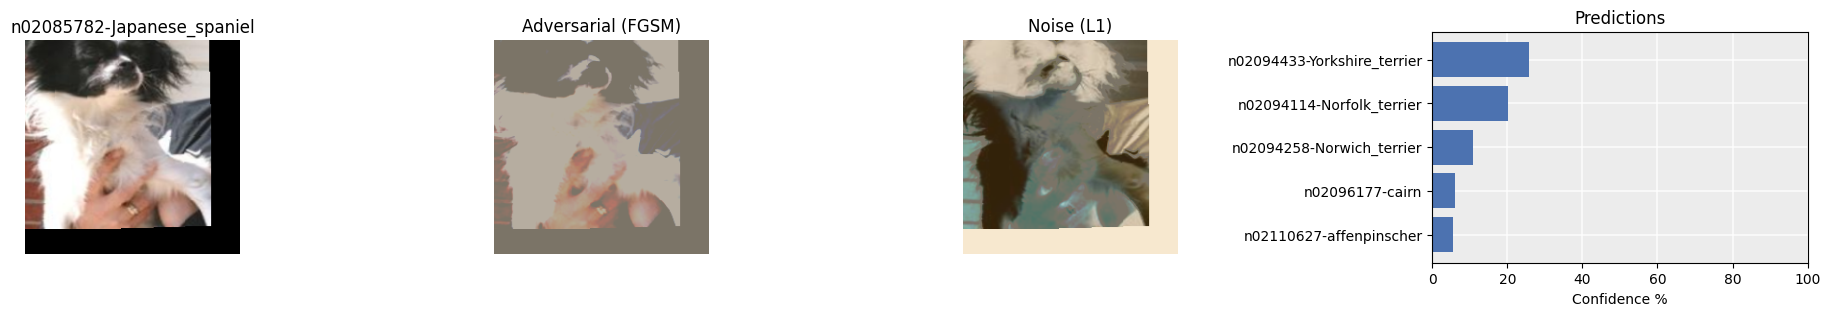

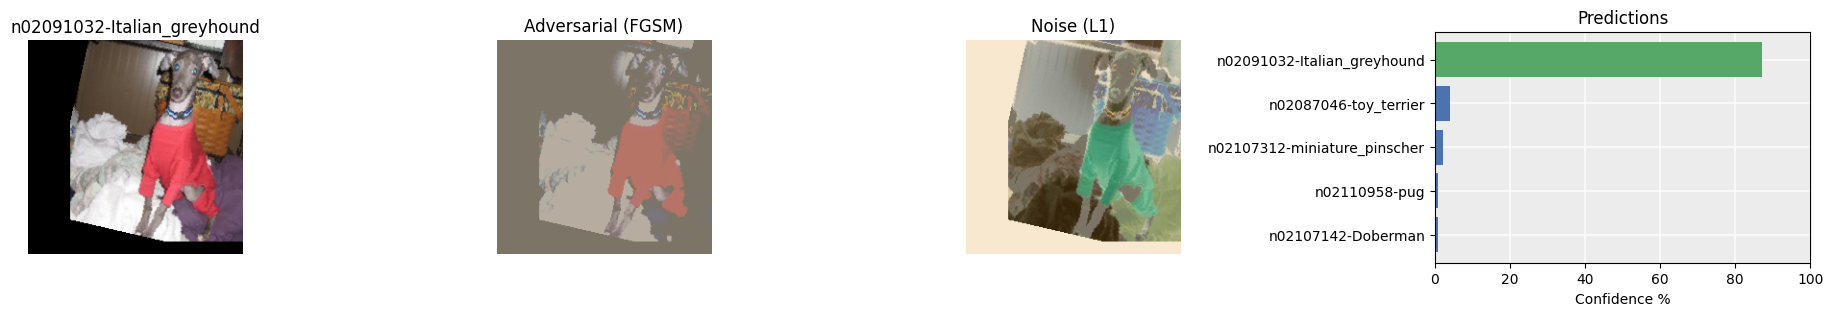

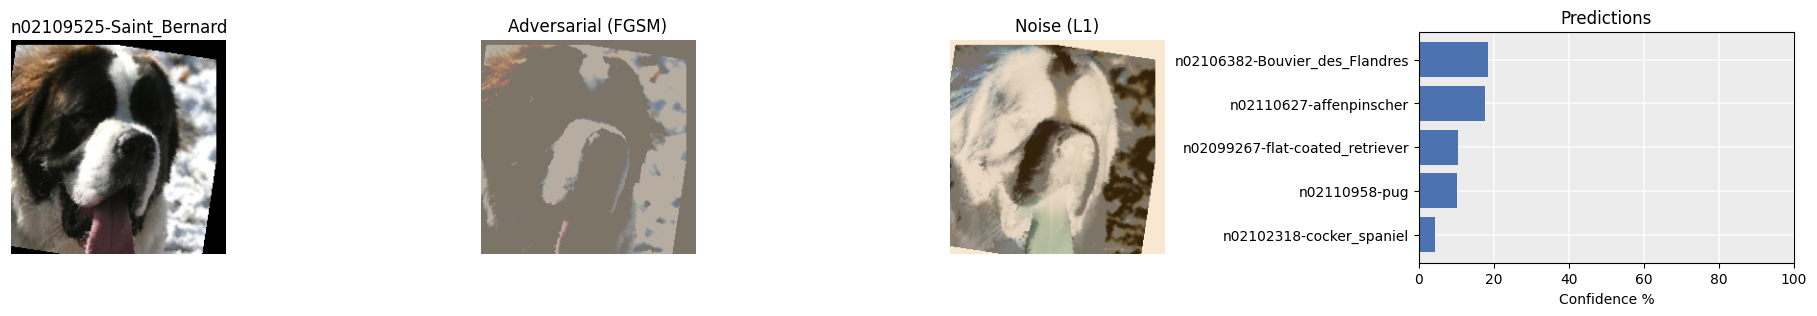

In [8]:
# Normalization factors used in your dataset
NORM_MEAN = torch.tensor([0.485, 0.456, 0.406])
NORM_STD = torch.tensor([0.229, 0.224, 0.225])

class_names = dataset.classes

# Functions to create adversarial examples
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

def pgd_attack(model, images, labels, eps, alpha, iters, norm='Linf'):
    # Copy the original images to perturb
    perturbed_images = images.clone().detach().requires_grad_(True)

    for _ in range(iters):
        outputs = model(perturbed_images)
        model.zero_grad()
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        grad = perturbed_images.grad.data

        # Perform the attack step
        if norm == "Linf":
            step = alpha * grad.sign()
        elif norm == "L2":
            g_norm = torch.norm(grad.view(grad.shape[0], -1), dim=1).view(-1, 1, 1, 1)
            step = alpha * grad / (g_norm + 1e-10)
        elif norm == "L1":
            step = alpha * grad / (grad.abs().sum(dim=[1,2,3], keepdim=True) + 1e-10)
        else:
            raise ValueError("Invalid norm choice.")

        # Apply the perturbation step while staying within the epsilon-ball and [0,1] range
        perturbed_images = perturbed_images + step
        perturbed_images = torch.min(torch.max(perturbed_images, images - eps), images + eps)
        perturbed_images = torch.clamp(perturbed_images, 0, 1).detach().requires_grad_(True)

    return perturbed_images


def tensor_to_img(tensor):
    # Move normalization tensors to the same device as the input tensor
    norm_mean = NORM_MEAN.to(tensor.device)
    norm_std = NORM_STD.to(tensor.device)

    tensor = tensor * norm_std[:, None, None] + norm_mean[:, None, None]
    tensor = torch.clamp(tensor, 0, 1)
    # Make sure to detach before calling numpy()
    img = tensor.detach().permute(1, 2, 0).cpu().numpy()
    return img

# Function to visualize adversarial examples
def visualize_adversarial_examples(model, dataloader, device, attack='fgsm', epsilon=0.003, alpha=0.01, iters=10, norm='L1'):
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)

    if attack == 'fgsm':
        images.requires_grad = True
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()
        data_grad = images.grad.data
        perturbed_images = fgsm_attack(images, epsilon, data_grad)
    elif attack == 'pgd':
        perturbed_images = pgd_attack(model, images, labels, epsilon, alpha, iters, norm)

    # Plot the results
    for i in range(min(len(images), 3)):
        original_img_np = tensor_to_img(images[i])
        perturbed_img_np = tensor_to_img(perturbed_images[i])
        noise_img_np = tensor_to_img(perturbed_images[i] - images[i])
        outputs = model(perturbed_images[i].unsqueeze(0))
        pred_probs, pred_classes = torch.topk(torch.softmax(outputs, dim=1).squeeze(), 5)

        fig, axes = plt.subplots(1, 4, figsize=(23, 3), gridspec_kw={'width_ratios': [2, 2, 2, 3.5], 'wspace': 1})

        axes[0].imshow(original_img_np)
        axes[0].set_title(f'{class_names[labels[i]]}')
        axes[0].axis('off')

        axes[1].imshow(perturbed_img_np)
        axes[1].set_title(f'Adversarial ({attack.upper()})')
        axes[1].axis('off')

        axes[2].imshow(noise_img_np)
        axes[2].set_title(f'Noise ({norm})')
        axes[2].axis('off')

        axes[3].barh(np.arange(5), pred_probs.detach().cpu().numpy() * 100,
                    color=['#55A868' if class_names[pred_classes[j]] == class_names[labels[i]] else '#4C72B0' for j in range(5)])
        axes[3].set_yticks(np.arange(5))
        axes[3].set_yticklabels([class_names[pred_classes[j]] for j in range(5)])
        axes[3].invert_yaxis()
        axes[3].set_xlabel('Confidence %')
        axes[3].set_title('Predictions')
        axes[3].set_xlim(0, 100)
        axes[3].set_facecolor('#ECECEC')
        axes[3].xaxis.grid(True, color='white', linestyle='-', linewidth=1.3, alpha=0.7)
        axes[3].yaxis.grid(True, color='white', linestyle='-', linewidth=1.3, alpha=0.7)
        axes[3].set_axisbelow(True)
        plt.tight_layout()
        plt.show()

# Check if a GPU is available and set PyTorch to use the GPU, otherwise use the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)

visualize_adversarial_examples(model, val_dataloader, device, attack='fgsm', epsilon=0.003)


# Evaluating Model Accuracy after Adversarial Training

This code section defines functions to calculate the accuracy of a model on clean and adversarial examples. It evaluates the model's performance under different adversarial attacks such as FGSM (Fast Gradient Sign Method) and PGD (Projected Gradient Descent) with varying norms.

In [9]:
def calculate_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    return accuracy

def calculate_adversarial_accuracy(model, dataloader, device, attack_fn, epsilon, alpha=None, iters=None, norm='Linf'):
    model.eval()
    correct = 0
    total = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        images.requires_grad = True
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()
        data_grad = images.grad.data
        if attack_fn == fgsm_attack:
            adv_images = attack_fn(images, epsilon, data_grad)
        elif attack_fn == pgd_attack:
            adv_images = attack_fn(model, images, labels, epsilon, alpha, iters, norm)
        else:
            raise ValueError("Unknown attack function")
        outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    accuracy = 100 * correct / total
    return accuracy


# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Evaluate clean accuracy
clean_accuracy = calculate_accuracy(model, val_dataloader, device)

# Norms and attack parameters
norms = ['L1', 'L2', 'Linf']
epsilon = 0.003
alpha = 0.01
iters = 10

# Evaluate FGSM and PGD attacks
fgsm_accuracies = {}
pgd_accuracies = {}

# FGSM is typically with Linf norm
fgsm_accuracies['Linf'] = calculate_adversarial_accuracy(
    model, val_dataloader, device, fgsm_attack, epsilon=epsilon
)

# Evaluate PGD for different norms
for norm in norms:
    pgd_accuracies[norm] = calculate_adversarial_accuracy(
        model, val_dataloader, device, pgd_attack, epsilon=epsilon, alpha=alpha, iters=iters, norm=norm
    )


# Print out the accuracies after Adversarial Training
print(f"Clean Accuracy: {clean_accuracy:.2f}%")
print(f"FGSM (Linf) Accuracy: {fgsm_accuracies['Linf']:.2f}%")
for norm in norms:
    print(f"PGD ({norm}) Accuracy: {pgd_accuracies[norm]:.2f}%")


Clean Accuracy: 79.98%
FGSM (Linf) Accuracy: 32.14%
PGD (L1) Accuracy: 34.11%
PGD (L2) Accuracy: 30.76%
PGD (Linf) Accuracy: 9.96%
